In [1]:
import pandas as pd
import ast

In [2]:
recipes_df = pd.read_csv('RAW_recipes.csv')
interactions_df = pd.read_csv('RAW_interactions.csv')

In [3]:
nutritions_list = ["calories", "total_fat", "sugar", "sodium", "protein", "sat_fat", "carbs"]

In [4]:
recipes_df['nutrition'] = recipes_df['nutrition'].apply(ast.literal_eval)

In [5]:
recipes_df[nutritions_list] = pd.DataFrame(recipes_df.nutrition.values.tolist(), index=recipes_df.index)

In [6]:
recipes_df = recipes_df.drop(['nutrition'], axis=1)

In [7]:
recipes_df.isnull().any()

name               True
id                False
minutes           False
contributor_id    False
submitted         False
tags              False
n_steps           False
steps             False
description        True
ingredients       False
n_ingredients     False
calories          False
total_fat         False
sugar             False
sodium            False
protein           False
sat_fat           False
carbs             False
dtype: bool

In [8]:
recipes_df = recipes_df.dropna(axis=0).reset_index(drop=True)

In [9]:
interactions_df.isnull().any()

user_id      False
recipe_id    False
date         False
rating       False
review        True
dtype: bool

In [10]:
interactions_df = interactions_df.dropna(axis=0)

In [11]:
complete_df = recipes_df.merge(interactions_df, left_on='id', right_on='recipe_id')

In [12]:
complete_df = complete_df[complete_df['minutes'] <= 500].reset_index(drop=True)

In [13]:
complete_df['minutes'].hist()

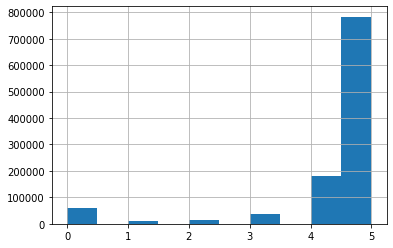

In [14]:
complete_df['rating'].hist()

In [15]:
# Most reviewed recipe
complete_df.groupby('name').count().idxmax()[0]

'best banana bread'

### How number of trials related to n_steps, time, each nutrition component and the ratings of others?

In [64]:
num_reviews_df = complete_df.groupby('id').count()

In [84]:
df = recipes_df.merge(num_reviews_df[['name']].copy(), left_on='id', right_on='id')\
               .rename(columns={'name_y': 'count'})[['count', 'minutes', 'n_steps', 'n_ingredients'] + nutritions_list]

In [106]:
df = df.rename(columns={'count': 'num_reviews'})

In [149]:
df.corr(method='spearman')

,num_reviews,minutes,n_steps,n_ingredients,calories,total_fat,sugar,sodium,protein,sat_fat,carbs
num_reviews,1.000000,-0.017206,-0.036153,-0.030389,-0.018589,-0.017220,-0.017583,0.019060,-0.003645,-0.009600,-0.013180
minutes,-0.017206,1.000000,0.412881,0.372314,0.252773,0.219254,0.113092,0.221391,0.268594,0.226404,0.189226
n_steps,-0.036153,0.412881,1.000000,0.448175,0.222797,0.221271,0.068838,0.139528,0.210223,0.235723,0.172929
n_ingredients,-0.030389,0.372314,0.448175,1.000000,0.252710,0.241082,0.102542,0.303544,0.310436,0.185380,0.194063
calories,-0.018589,0.252773,0.222797,0.252710,1.000000,0.831102,0.320976,0.585699,0.725884,0.750198,0.645057
total_fat,-0.017220,0.219254,0.221271,0.241082,0.831102,1.000000,0.122188,0.540828,0.630811,0.920664,0.297685
sugar,-0.017583,0.113092,0.068838,0.102542,0.320976,0.122188,1.000000,0.030280,-0.042320,0.130432,0.626300
sodium,0.019060,0.221391,0.139528,0.303544,0.585699,0.540828,0.030280,1.000000,0.671058,0.480858,0.304186
protein,-0.003645,0.268594,0.210223,0.310436,0.725884,0.630811,-0.042320,0.671058,1.000000,0.559546,0.279243
sat_fat,-0.009600,0.226404,0.235723,0.185380,0.750198,0.920664,0.130432,0.480858,0.559546,1.000000,0.274632


In [140]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0, 0.5, 'number of reviews')

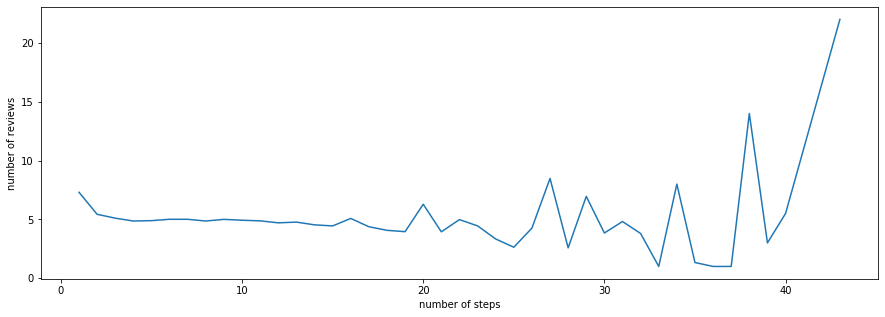

In [143]:
plt.figure(figsize=(15, 5))
plt.plot(df_grouped.index, df_grouped['num_reviews'])
plt.xlabel('number of steps')
plt.ylabel('number of reviews')

In [ ]:
# User preference:
# rating with cooking complexity: time and number of steps
# rating with health index

# Recipe Related:
# nations with average nutritions -> nutrition value of recipes of each country.
# similarities between dishes based on ingredients or instructions 
# or description or cooking method (groupby country to see similarity between countries)
# NLP approach sources available online: search "recipe similarity"
# nations with taste (0.1 * sour, 0.2 * salty, 0.6 * spicy, 0.1 * bitter)

# Regression Model: ingredients + cooking Method (need quatities) -> nutritions
# Classification Model: ingredients -> taste (sour, sweet, bitter, spicy, salty) or symnonyms

In [117]:
complete_df['taste'] = [list() for x in range(len(complete_df.index))]

In [118]:
taste_word_dict = {'sour': ['acid', 'acidic', 'sour', 'tart', 'vinegary', 'citrus', 'lemon'],
                   'bitter': ['bitter', 'harsh'],
                   'salty': ['brackish', 'salty', 'briny', 'saline'],
                   'sweet': ['dulcet', 'sweet', 'honeyed', 'dulcified', 'edulcorated', 'sweetened', 'candied','syrupy', 'sugarcoated', 'nectarous', 'candy', 'fudge'],
                   'spicy': ['spicy','peppery', 'piquant', 'pungent', 'burning', 'fiery', 'gingery', 'sharp', 'stinging', 'zesty', 'sugary', 'chili', 'chutneys', 'curries', 'peppers']}

In [119]:
for taste in taste_word_dict.keys():
    recipes = complete_df.review.str.lower().apply(lambda x: any(word in x for word in taste_word_dict[taste]))\
              | complete_df.tags.apply(lambda x: any(word in x for word in taste_word_dict[taste]))\
              | complete_df.description.str.lower().apply(lambda x: any(word in x for word in taste_word_dict[taste]))
    complete_df.taste.loc[recipes] = complete_df[recipes].taste.apply(lambda l:l + [taste])

/Users/jiahuawu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [120]:
taste_df = complete_df[complete_df.taste.apply(lambda l: len(l) > 0)].groupby(['id', 'name']).agg({'taste':'sum'})

In [121]:
taste_df['taste'] = taste_df['taste'].apply(set)

In [123]:
taste_df.to_csv('taste_df.csv')

In [128]:
taste_recipes_df = taste_df.merge(recipes_df, left_on='id', right_on='id').drop('taste_y', axis=1).rename(columns={'taste_x': 'taste'})

## Scraper Test

In [1]:
url = 'https://www.food.com/recipe/buttermilk-pie-with-gingersnap-crumb-crust-45?mode=Metric&scaleto=8'

In [2]:
from recipe_scrapers import scrape_me

In [3]:
scraper = scrape_me(url)

In [5]:
scraper.ingredients()

['177.44 ml sugar',
 '14.79 ml margarine',
 '1 egg',
 '2 egg whites',
 '44.37 ml flour',
 '1.23 ml salt',
 '236.59 ml buttermilk',
 '118.29 ml graham cracker crumbs',
 '118.29 ml gingersnap crumbs',
 '29.58 ml margarine']

### Search for unique tag

In [69]:
unique_tag = recipes_df.explode('tags')['tags'].unique()

In [72]:
sorted(unique_tag.tolist())

['',
 '1-day-or-more',
 '15-minutes-or-less',
 '3-steps-or-less',
 '30-minutes-or-less',
 '4-hours-or-less',
 '5-ingredients-or-less',
 '60-minutes-or-less',
 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.',
 'a1-sauce',
 'african',
 'american',
 'amish-mennonite',
 'angolan',
 'appetizers',
 'apples',
 'april-fools-day',
 'argentine',
 'artichoke',
 'asian',
 'asparagus',
 'australian',
 'austrian',
 'avocado',
 'bacon',
 'baja',
 'baked-beans',
 'baking',
 'bananas',
 'bar-cookies',
 'barbecue',
 'bass',
 'bean-soup',
 'beans',
 'beans-side-dishes',
 'bear',
 'beef',
 'beef-barley-soup',
 'beef-crock-pot',
 'beef-kidney',
 'beef-liver',
 'beef-organ-meats',
 'beef-ribs',
 'beef-sauces',
 'beef-sausage',
 'beginner-cook',
 'beijing',
 'belgian',
 'berries',
 'beverages',
 'birthday',
 'biscotti',
 'bisques-cream-soups',
 'black-bean-soup',
 'black-beans',
 'blueberries',
 'bok-choys',
 'brazilian',
 'bread-machine',
 'bread-pudding',
 'breads',
 'breakfast',
 '